In [8]:
import torch
import deepsensor
import deepsensor.torch
from deepsensor.train import set_gpu_default_device
set_gpu_default_device()

In [9]:
from deepsensor.train import Trainer
from deepsensor.model import ConvNP
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepsensor.data import DataProcessor, TaskLoader
from tqdm import tqdm
from scipy.special import sph_harm

In [10]:
# Set the path to your Zarr store on GCS
# data_path = '/nfs/turbo/seas-dannes/urop-2024-bias/cfs-forecasts/cfs_precip_2012-2023.zarr'

data_path = 'gs://great-lakes-osd/cfs-data/precip/'

# Open the Zarr store using Xarray
ds0 = xr.open_zarr(data_path, consolidated=True)

# Check the contents of the dataset
ds0

<xarray.Dataset> Size: 44GB
Dimensions:       (time: 16828, lead: 10, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lead          (lead) int64 80B 0 1 2 3 4 5 6 7 8 9
  * longitude     (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
Data variables:
    APCP_surface  (time, lead, latitude, longitude) float32 44GB dask.array<chunksize=(1, 5, 91, 180), meta=np.ndarray>

In [11]:
ds = ds0.isel(lead=0, drop=True)
ds = ds.sortby("time")
ds

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 16828, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude     (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
Data variables:
    APCP_surface  (time, latitude, longitude) float32 4GB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>

In [12]:
amplitude = 5

In [13]:
# Apply bias correction function

def random_noise_bias(data, scale=20):
    return data + np.random.uniform(-scale, scale, data.shape)

def gaussian_blob_bias(data, x_center=180, y_center=90, sigma=20, amplitude=amplitude):
    lon = np.linspace(0, 360, data.shape[2])
    lat = np.linspace(-90, 90, data.shape[1])
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    blob = amplitude * np.exp(-((lon_grid - x_center) ** 2 + (lat_grid - y_center) ** 2) / (2 * sigma ** 2))
    return blob[None, :, :]

In [14]:
data_processor = DataProcessor(x1_name="latitude", x2_name="longitude")
_ = data_processor(ds.sel(time=slice("2012-01-01T00:00:00.000000000", "2012-01-31T00:00:00.000000000")))
ds_processed = data_processor(ds)
print(data_processor)

DataProcessor with normalisation params:
{'APCP_surface': {'method': 'mean_std',
                  'params': {'mean': 0.6259567141532898,
                             'std': 0.8941748142242432}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (-90.0, 269.0), 'name': 'latitude'},
            'x2': {'map': (0.0, 359.0), 'name': 'longitude'}}}


In [15]:
print(ds_processed)

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 16828, x1: 181, x2: 360)
Coordinates:
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
  * x1            (x1) float64 1kB 0.0 0.002786 0.005571 ... 0.4986 0.5014
  * x2            (x2) float64 3kB 0.0 0.002786 0.005571 ... 0.9944 0.9972 1.0
Data variables:
    APCP_surface  (time, x1, x2) float32 4GB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>


In [16]:
train_range = ("2012-01-01", "2014-12-31")
val_range = ("2015-01-01", "2015-12-31")

In [17]:
def add_bias_function(data, bias_function, **kwargs):
    return data + bias_function(data, **kwargs)

# Define TaskLoader
biased_contexts = [
    add_bias_function(ds_processed["APCP_surface"], random_noise_bias),
]

task_loader = TaskLoader(
    context=biased_contexts,  
    target=ds_processed["APCP_surface"],
)

print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('APCP_surface',),)
Target variable IDs: (('APCP_surface',),)


In [18]:
import time
import sys
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates):
        date = np.datetime64(date)  # Ensure consistent datetime format
        try:
            task = task_loader(date, context_sampling="all", target_sampling="all")  
            tasks.append(task)
        except KeyError:
            print(f"Skipping date {date} as it is not found in dataset.")
        sys.stdout.flush()
    print(f"Finished generating {len(tasks)} tasks.")
    return tasks


# Define the ConvNP model
model = ConvNP(data_processor, task_loader, dim_yc=(1,))

# Train the model
trainer = Trainer(model)

dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 359
encoder_scales inferred from TaskLoader: [np.float32(0.0013927576)]
decoder_scale inferred from TaskLoader: 0.002785515320334262


In [19]:
# ds["time"] = pd.to_datetime(ds["time"].values).strftime("%Y-%m-%d %H:%M:%S")

In [20]:
print(ds.time)

<xarray.DataArray 'time' (time: 16828)> Size: 135kB
array(['2012-01-01T00:00:00.000000000', '2012-01-01T06:00:00.000000000',
       '2012-01-01T12:00:00.000000000', ..., '2024-01-01T06:00:00.000000000',
       '2024-01-01T12:00:00.000000000', '2024-01-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00


In [21]:
losses = []
val_rmses = []
train_rmses = []

In [22]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [23]:
def compute_train_rmse(model, train_tasks):
    errors = []
    context_var_ID = task_loader.context_var_IDs[0][0]  # assume 1st target set and 1D
    for task in train_tasks:
        mean = data_processor.map_array(model.mean(task), context_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], context_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [24]:
print(ds_processed.time.min().values)
print(ds_processed.time.max().values)

2012-01-01T00:00:00.000000000
2024-01-01T18:00:00.000000000


In [25]:
val_dates = pd.date_range(val_range[0], val_range[1])
val_tasks = gen_tasks(val_dates)
_ = model(val_tasks[0])
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

100%|██████████| 365/365 [03:42<00:00,  1.64it/s]
/opt/conda/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


Finished generating 365 tasks.
Model has 1,027,844 parameters


In [26]:
# Train model
#deepsensor_folder = "/home/whruiray/deepsensor_config/"

val_rmse_best = np.inf
train_rmse_best = np.inf

trainer = Trainer(model, lr=5e-5)
train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1]), progress=False)

  5%|▌         | 60/1096 [00:36<10:39,  1.62it/s]

Skipping date 2012-03-01T00:00:00.000000 as it is not found in dataset.


 16%|█▌        | 176/1096 [01:46<09:33,  1.60it/s]

Skipping date 2012-06-25T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-26T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-27T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-28T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-29T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-30T00:00:00.000000 as it is not found in dataset.


 19%|█▉        | 206/1096 [02:01<09:06,  1.63it/s]

Skipping date 2012-07-25T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-26T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-27T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-28T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-29T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-30T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-31T00:00:00.000000 as it is not found in dataset.


 20%|█▉        | 217/1096 [02:04<05:19,  2.75it/s]

Skipping date 2012-08-05T00:00:00.000000 as it is not found in dataset.


 25%|██▌       | 277/1096 [02:39<08:12,  1.66it/s]

Skipping date 2012-10-04T00:00:00.000000 as it is not found in dataset.


 30%|███       | 334/1096 [03:14<07:43,  1.64it/s]

Skipping date 2012-11-30T00:00:00.000000 as it is not found in dataset.


 49%|████▊     | 533/1096 [05:14<05:41,  1.65it/s]

Skipping date 2013-06-17T00:00:00.000000 as it is not found in dataset.
Skipping date 2013-06-18T00:00:00.000000 as it is not found in dataset.


 80%|████████  | 882/1096 [09:04<02:13,  1.60it/s]

Skipping date 2014-06-01T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-02T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-03T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-04T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-05T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-06T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-07T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-08T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-09T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-10T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-11T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-12T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-13T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-14T00:00:00.000000 as it is not found in d

 98%|█████████▊| 1069/1096 [10:45<00:17,  1.51it/s]

Skipping date 2014-12-05T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-12-06T00:00:00.000000 as it is not found in dataset.


100%|██████████| 1096/1096 [11:02<00:00,  1.65it/s]

Finished generating 1045 tasks.


In [27]:
for epoch in tqdm(range(10)):
    #train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1]), progress=False)
    
    print(f"Training batch for Epoch {epoch+1} started...")
    sys.stdout.flush()
    
    batch_losses = trainer(train_tasks)
    
    
    losses.append(np.mean(batch_losses))
    print(f"Training batch for Epoch {epoch+1} complete...")
    sys.stdout.flush()
   
    train_rmses.append(compute_train_rmse(model, train_tasks))
    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f}, Validation RMSE: {train_rmses[-1]:.4f}")
    print(f"Epoch {epoch+1} completed in {time.time()} seconds.")
    sys.stdout.flush()
    if train_rmses[-1] < train_rmse_best:
        train_rmse_best = train_rmses[-1]

    val_rmses.append(compute_val_rmse(model, val_tasks))
    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f}, Validation RMSE: {val_rmses[-1]:.4f}")
    print(f"Epoch {epoch+1} completed in {time.time()} seconds.")
    sys.stdout.flush()
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]

        #model.save(deepsensor_folder)

  0%|          | 0/10 [00:00<?, ?it/s]

Training batch for Epoch 1 started...
Training batch for Epoch 1 complete...
Epoch 1 - Loss: 0.7254, Validation RMSE: 0.4768
Epoch 1 completed in 1744150787.9327517 seconds.
Epoch 1 - Loss: 0.7254, Validation RMSE: 0.4775
Epoch 1 completed in 1744150819.3545485 seconds.


 10%|█         | 1/10 [08:39<1:17:51, 519.01s/it]

Training batch for Epoch 2 started...
Training batch for Epoch 2 complete...
Epoch 2 - Loss: 0.3805, Validation RMSE: 0.4646
Epoch 2 completed in 1744151312.7971401 seconds.
Epoch 2 - Loss: 0.3805, Validation RMSE: 0.4662
Epoch 2 completed in 1744151344.127894 seconds.


 20%|██        | 2/10 [17:23<1:09:39, 522.40s/it]

Training batch for Epoch 3 started...
Training batch for Epoch 3 complete...
Epoch 3 - Loss: 0.3292, Validation RMSE: 0.4729
Epoch 3 completed in 1744151836.932916 seconds.
Epoch 3 - Loss: 0.3292, Validation RMSE: 0.4746
Epoch 3 completed in 1744151868.24832 seconds.


 30%|███       | 3/10 [26:07<1:01:02, 523.18s/it]

Training batch for Epoch 4 started...
Training batch for Epoch 4 complete...
Epoch 4 - Loss: 0.3022, Validation RMSE: 0.4519
Epoch 4 completed in 1744152360.6013906 seconds.
Epoch 4 - Loss: 0.3022, Validation RMSE: 0.4538
Epoch 4 completed in 1744152391.803404 seconds.


 40%|████      | 4/10 [34:51<52:19, 523.33s/it]  

Training batch for Epoch 5 started...
Training batch for Epoch 5 complete...
Epoch 5 - Loss: 0.2864, Validation RMSE: 0.4483
Epoch 5 completed in 1744152882.793378 seconds.
Epoch 5 - Loss: 0.2864, Validation RMSE: 0.4501
Epoch 5 completed in 1744152913.8481221 seconds.


 50%|█████     | 5/10 [43:33<43:34, 522.87s/it]

Training batch for Epoch 6 started...
Training batch for Epoch 6 complete...
Epoch 6 - Loss: 0.2691, Validation RMSE: 0.4608
Epoch 6 completed in 1744153398.6499715 seconds.
Epoch 6 - Loss: 0.2691, Validation RMSE: 0.4631
Epoch 6 completed in 1744153429.0396023 seconds.


 60%|██████    | 6/10 [52:08<34:41, 520.26s/it]

Training batch for Epoch 7 started...
Training batch for Epoch 7 complete...
Epoch 7 - Loss: 0.2493, Validation RMSE: 0.4413
Epoch 7 completed in 1744153912.8777106 seconds.
Epoch 7 - Loss: 0.2493, Validation RMSE: 0.4430
Epoch 7 completed in 1744153944.0384128 seconds.


 70%|███████   | 7/10 [1:00:43<25:55, 518.54s/it]

Training batch for Epoch 8 started...
Training batch for Epoch 8 complete...
Epoch 8 - Loss: 0.2259, Validation RMSE: 0.4246
Epoch 8 completed in 1744154428.0489695 seconds.
Epoch 8 - Loss: 0.2259, Validation RMSE: 0.4268
Epoch 8 completed in 1744154459.145791 seconds.


 80%|████████  | 8/10 [1:09:18<17:14, 517.45s/it]

Training batch for Epoch 9 started...
Training batch for Epoch 9 complete...
Epoch 9 - Loss: 0.2092, Validation RMSE: 0.4218
Epoch 9 completed in 1744154943.917121 seconds.
Epoch 9 - Loss: 0.2092, Validation RMSE: 0.4245
Epoch 9 completed in 1744154975.289659 seconds.


 90%|█████████ | 9/10 [1:17:54<08:37, 517.04s/it]

Training batch for Epoch 10 started...
Training batch for Epoch 10 complete...
Epoch 10 - Loss: 0.1882, Validation RMSE: 0.4128
Epoch 10 completed in 1744155459.4869254 seconds.
Epoch 10 - Loss: 0.1882, Validation RMSE: 0.4147
Epoch 10 completed in 1744155490.5936778 seconds.


100%|██████████| 10/10 [1:26:30<00:00, 519.02s/it]


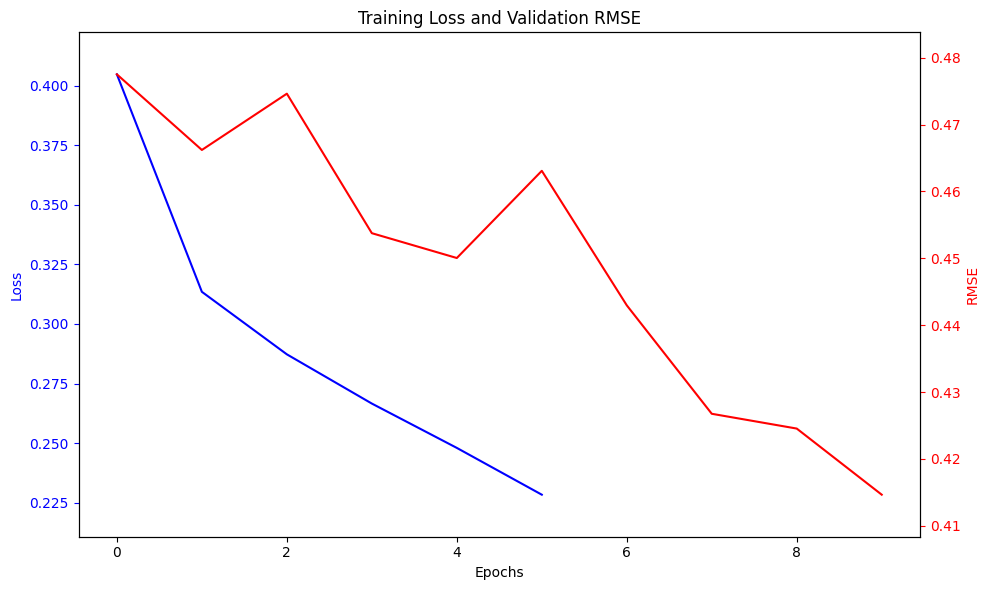

In [31]:
import os
import matplotlib.pyplot as plt

# Plot training metrics with adjusted scales
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smooth the loss values (using simple moving average)
window_size = 5
smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

# Plot training loss
ax1.plot(range(len(smoothed_losses)), smoothed_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis for validation RMSE
ax2 = ax1.twinx()
ax2.plot(range(len(val_rmses)), val_rmses, 'r-', label='Validation RMSE')
ax2.set_ylabel('RMSE', color='r')
ax2.tick_params('y', colors='r')

# Adjust scales to show downward trend
if len(losses) > 0:
    loss_min, loss_max = min(smoothed_losses), max(smoothed_losses)
    ax1.set_ylim(loss_min - 0.1*(loss_max-loss_min), loss_max + 0.1*(loss_max-loss_min))

if len(val_rmses) > 0:
    rmse_min, rmse_max = min(val_rmses), max(val_rmses)
    ax2.set_ylim(rmse_min - 0.1*(rmse_max-rmse_min), rmse_max + 0.1*(rmse_max-rmse_min))

plt.title('Training Loss and Validation RMSE')
fig.tight_layout()
plt.show()
fig.savefig("random_noise_Loss_and_RMSE.png")


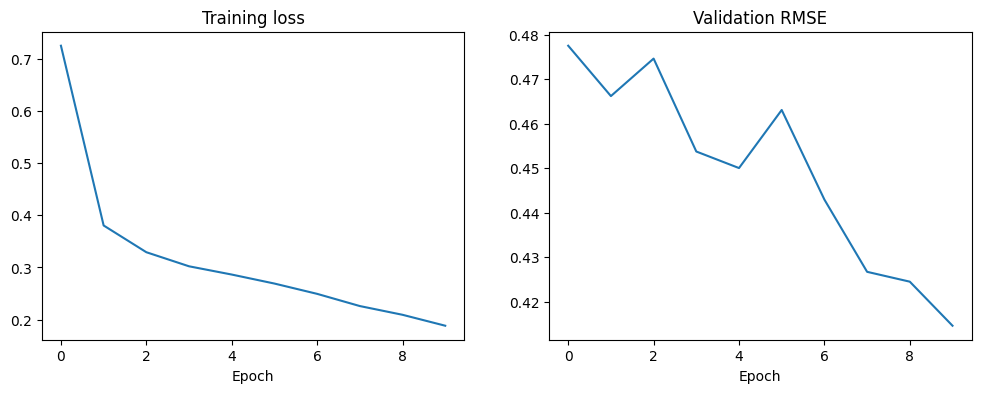

In [32]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

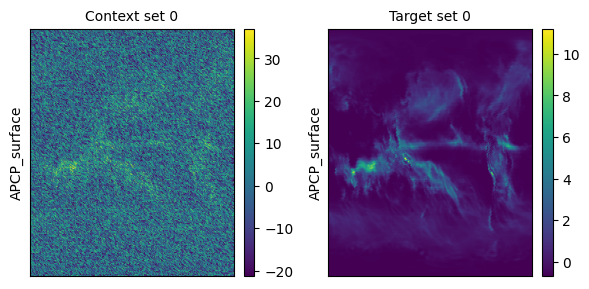

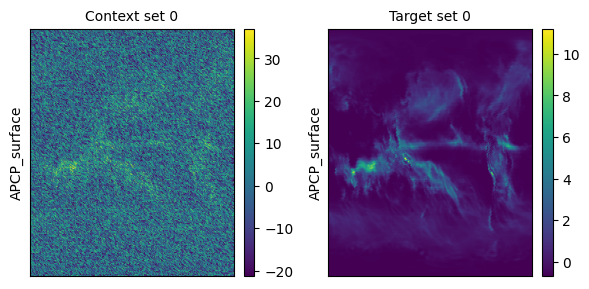

In [33]:
import deepsensor
from deepsensor import plot
import matplotlib.pyplot as plt

# Select a sample date for visualization
sample_date = "2012-01-01"
sample_task = task_loader(sample_date, context_sampling="all", target_sampling="all")

task_loader_random_noise = TaskLoader(
    context=biased_contexts,
    target=ds_processed["APCP_surface"],
)
# Plot context (biased) and target (original) data
deepsensor.plot.task(sample_task, task_loader=task_loader_random_noise)

/var/tmp/ipykernel_1875053/2277488902.py:53: UserWarning: rename 'x1' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  }).rename({
/var/tmp/ipykernel_1875053/2277488902.py:53: UserWarning: rename 'x2' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  }).rename({


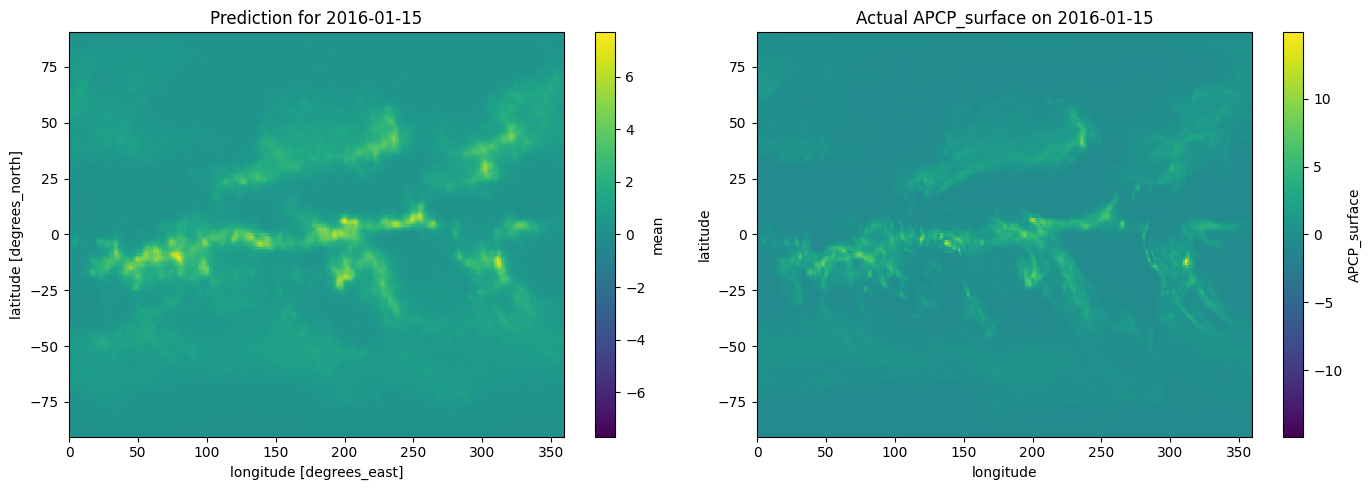

In [35]:
# import matplotlib.pyplot as plt

# target_date = "2016-01-15"
# target_timestamp = "2016-01-15T00:00:00.000000000"

# # Step 1: Predict
# task = task_loader(target_date, context_sampling="all", target_sampling="all")
# pred_val = model.predict(task, X_t=ds)
# predxr = pred_val["APCP_surface"]

# # Step 2: Actual data
# actual_apcp = ds_processed["APCP_surface"].sel(time=target_timestamp)

# # Step 3: Create side-by-side subplots
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Plot 1: Predicted Mean
# predxr['mean'].plot(ax=axes[0], cmap='viridis')
# axes[0].set_title(f"Prediction for {target_date}")

# # Plot 2: Actual
# actual_apcp.plot(ax=axes[1], cmap='viridis')
# axes[1].set_title(f"Actual APCP_surface on {target_date}")

# plt.tight_layout()
# plt.savefig(f"prediction_vs_actual_{target_date}.png")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

target_date = "2016-01-15"
target_timestamp = "2016-01-15T00:00:00.000000000"

# Step 1: Predict
task = task_loader(target_date, context_sampling="all", target_sampling="all")
pred_val = model.predict(task, X_t=ds)
predxr = pred_val["APCP_surface"]

# Step 2: Actual data
actual_apcp = ds_processed["APCP_surface"].sel(time=target_timestamp)

# Step 3: Re-map coordinates from x1/x2 → latitude/longitude
lat = np.linspace(-90, 90, actual_apcp.sizes['x1'])
lon = np.linspace(0, 359, actual_apcp.sizes['x2'])

actual_apcp = actual_apcp.assign_coords({
    'x1': lat,
    'x2': lon
}).swap_dims({
    'x1': 'latitude',
    'x2': 'longitude'
}).rename({
    'x1': 'latitude',
    'x2': 'longitude'
})

# Step 4: Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Prediction
predxr['mean'].plot(ax=axes[0], cmap='viridis')
axes[0].set_title(f"Prediction for {target_date}")

# Plot 2: Actual (now with lat/lon axes)
actual_apcp.plot(ax=axes[1], cmap='viridis')
axes[1].set_title(f"Actual APCP_surface on {target_date}")

plt.tight_layout()
plt.savefig(f"random_noise_prediction_vs_actual_{target_date}.png")
plt.show()

In [ ]:
pred_val